<a href="https://www.kaggle.com/code/lukalafaye/fine-tuning-yolo-art?scriptVersionId=210664718" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Install dependencies

In [84]:
!pip install torch -q
!git clone https://github.com/IDEA-Research/GroundingDINO 
!pip install -e GroundingDINO -q

fatal: destination path 'GroundingDINO' already exists and is not an empty directory.


# Import dependencies

In [85]:
import os
import sys

# Add 'GroundingDINO' to the PYTHONPATH
os.environ['PYTHONPATH'] = f"GroundingDINO:{os.environ.get('PYTHONPATH', '')}"
sys.path.append('GroundingDINO')

In [86]:
import torch
import sys
import os
import supervision as sv
import torchvision.transforms as T
from PIL import Image
import numpy as np
import groundingdino
from groundingdino.util.inference import load_model, load_image, predict, annotate
from datasets import load_dataset
from tqdm import tqdm
import yaml
import json
import warnings
import requests
from torchvision import transforms
from datasets import DatasetDict

## Cuda and libGL test

In [87]:
if torch.cuda.is_available():
    print("GPU will be used.")
    device = torch.device("cuda")
else:
    print("CUDA is not available. CPU will be used.")
    device = torch.device("cpu")

!ldconfig -p | grep libGL.so.1

GPU will be used.
	libGL.so.1 (libc6,x86-64) => /lib/x86_64-linux-gnu/libGL.so.1


# Remove warnings and prepare DINO installation

In [88]:
warnings.filterwarnings("ignore", category=UserWarning)
os.environ["TOKENIZERS_PARALLELISM"] = "false"
sys.path.append('/kaggle/working/GroundingDINO')

## Load DINO model

In [89]:
!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth
model = load_model('GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py', 'groundingdino_swint_ogc.pth')

final text_encoder_type: bert-base-uncased


In [90]:
def run_dino(dino, image, text_prompt='food', box_threshold=0.4, text_threshold=0.1):
    boxes, logits, phrases = predict(
        model = dino, 
        image = image, 
        caption = text_prompt, 
        box_threshold = box_threshold, 
        text_threshold = text_threshold
    )
    return boxes, logits, phrases

## Image painting DINO test

In [125]:
from PIL import Image
import numpy as np
import torchvision.transforms as T

def preprocess_image(image):
    """
    Preprocess the image for GroundingDINO.
    - Handles PIL Image, PngImageFile, or image paths.
    - Converts the image to RGB and resizes it to 640x640.
    - Normalizes and returns the image tensor and the original image.
    """
    if isinstance(image, str):  # If the input is a file path
        image = Image.open(image).convert("RGB")
    elif isinstance(image, np.ndarray):  # If the input is a NumPy array
        image = Image.fromarray(image).convert("RGB")
    elif not isinstance(image, Image.Image):  # For unexpected types
        raise ValueError("Unsupported image type. Must be file path, NumPy array, or PIL Image.")

    transform = T.Compose([
        T.Resize((640, 640)),  
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    image_tensor = transform(image)
    image_np = np.array(image)

    return image_tensor, image_np

In [126]:

url = "https://static01.nyt.com/images/2020/02/02/arts/02met1/02met1-superJumbo.jpg"
response = requests.get(url)

with open("painting.jpg", "wb") as file:
    file.write(response.content)

print("Image saved as painting.jpg")

Image saved as painting.jpg


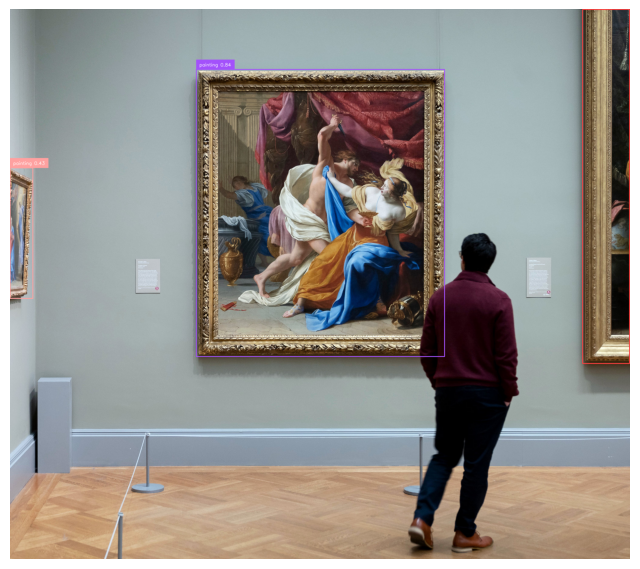

In [127]:
image_path = "/kaggle/working/painting.jpg"
image_tensor, original_image = preprocess_image(image_path)
text_prompt = "painting"  # Replace with your desired object
boxes, logits, phrases = run_dino(model, image_tensor, text_prompt)
annotated_frame = annotate(image_source=original_image, boxes=boxes, logits=logits, phrases=phrases)
sv.plot_image(annotated_frame, (8, 8))

## Preparing dataset for finetuning

In [94]:
!rm -rf data/

In [95]:
dataset = load_dataset('anand94ap/orangerie_museum_art_piece')
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 159
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 106
    })
})

In [96]:
text_prompt = "painting"
images = dataset["train"]["image"][:20]

## Data augmentation

In [141]:
import os
from tqdm import tqdm

def fetch_labels(dino, data, data_size, data_dir):
    data = data.train_test_split(train_size=min(len(data), data_size))['train']

    image_dir = f'{data_dir}/images'
    label_dir = f'{data_dir}/labels'
    os.makedirs(image_dir, exist_ok=True)
    os.makedirs(label_dir, exist_ok=True)
    
    for i, d in enumerate(tqdm(data, desc="Processing data")):
        image_path = f'{image_dir}/{i:06d}.png'
        label_path = f'{label_dir}/{i:06d}.txt'
        
        # Resize and save image
        image = d['image'].resize((640, 640))
        image.save(image_path, "PNG")
        
        # Load image and run the model
        image_source, processed_image = load_image(image_path)
        boxes, logits, phrases = run_dino(dino, processed_image)

        # Get painting label ID
        painting_id = str(d['label'])
        
        if boxes is not None and len(boxes) > 0:
            # Construct YOLO label lines: <class_id> <center_x> <center_y> <width> <height>
            label = [
                f"{painting_id} " + " ".join(map(str, b))
                for b in boxes.tolist()
            ]
            label = "\n".join(label)
        else:
            # Handle cases where no boxes are detected
            label = ""

        # Write labels to the file
        with open(label_path, 'w') as f:
            f.write(label)


In [135]:
print(set(dataset["train"]["label"]))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90}


In [139]:
fetch_labels(model, dataset['train'], 'data/train')
fetch_labels(model, dataset['validation'], 'data/valid')

AttributeError: 'numpy.ndarray' object has no attribute 'save'

## Check labels

In [100]:
import os

def validate_labels(label_dir, num_classes):
    errors = []
    for label_file in os.listdir(label_dir):
        if not label_file.endswith(".txt"):
            continue
        with open(os.path.join(label_dir, label_file), "r") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) != 5:
                    errors.append(f"Invalid line in {label_file}: {line.strip()}")
                else:
                    class_id = int(parts[0])
                    if class_id < 0 or class_id >= num_classes:
                        errors.append(f"Invalid class ID {class_id} in {label_file}")
    return errors

# Validate
label_dir = "/kaggle/working/data/train/labels"
num_classes = 100  # Update with your dataset's number of classes
errors = validate_labels(label_dir, num_classes)

if errors:
    print("Label errors:")
    for error in errors:
        print(error)
else:
    print("All labels are valid.")

All labels are valid.


In [101]:
import os

def check_images_labels(image_dir, label_dir):
    missing_images = []
    for label_file in os.listdir(label_dir):
        if not label_file.endswith(".txt"):
            continue
        # Match image file name with label file name
        image_file = os.path.join(image_dir, label_file.replace(".txt", ".png"))
        if not os.path.exists(image_file):
            missing_images.append(image_file)
    return missing_images

image_dir = "/kaggle/working/data/train/images"
label_dir = "/kaggle/working/data/train/labels"

missing_images = check_images_labels(image_dir, label_dir)

if missing_images:
    print("Missing images:")
    for img in missing_images:
        print(img)
else:
    print("All images are present.")

All images are present.


## Generate class names

In [102]:
import json

json_file = "/kaggle/input/labelsyolo22/label_mapping.json"

with open(json_file, "r", encoding="utf-8") as file:
    data = json.load(file)

data["id2label"]

{'0': 'Antonia - Amedeo Modigliani',
 '1': 'Arlequin a la guitare - Andre Derain',
 '2': 'Cartes a jouer verre et bouteille sur un gueridon - Pablo Picasso',
 '3': 'Cartes a jouer, paquet de tabac, bouteille et verre - Pablo Picasso',
 '4': 'Coupe de fruit avec poires et pommes - Pablo Picasso',
 '5': 'Danseuses espagnoles - Marie Laurencin',
 '6': 'Eglise Saint-Pierre - Maurice Utrillo',
 '7': 'Eglise de Clignancourt - Maurice Utrillo',
 '8': 'Elements vegetaux - Henri Matisse',
 '9': 'Etude de pomme - Paul Cezanne',
 '10': 'Femme a la mandoline - Henri Matisse',
 '11': 'Femme au chapeau blanc - Pablo Picasso',
 '12': 'Femme au tambourin - Pablo Picasso',
 '13': 'Femme au violon - Henri Matisse',
 '14': 'Femmes au canape - Henri Matisse',
 '15': 'Femmes au chien - Marie Laurencin',
 '16': 'Grand nu couche - Andre Derain',
 '17': 'Grande baigneuse - Pablo Picasso',
 '18': 'Grande cathedrale - Maurice Utrillo',
 '19': 'Guitare et journal - Pablo Picasso',
 '20': 'Homme assis a une table

In [103]:
class_names = list(data["id2label"].values())
class_names

['Antonia - Amedeo Modigliani',
 'Arlequin a la guitare - Andre Derain',
 'Cartes a jouer verre et bouteille sur un gueridon - Pablo Picasso',
 'Cartes a jouer, paquet de tabac, bouteille et verre - Pablo Picasso',
 'Coupe de fruit avec poires et pommes - Pablo Picasso',
 'Danseuses espagnoles - Marie Laurencin',
 'Eglise Saint-Pierre - Maurice Utrillo',
 'Eglise de Clignancourt - Maurice Utrillo',
 'Elements vegetaux - Henri Matisse',
 'Etude de pomme - Paul Cezanne',
 'Femme a la mandoline - Henri Matisse',
 'Femme au chapeau blanc - Pablo Picasso',
 'Femme au tambourin - Pablo Picasso',
 'Femme au violon - Henri Matisse',
 'Femmes au canape - Henri Matisse',
 'Femmes au chien - Marie Laurencin',
 'Grand nu couche - Andre Derain',
 'Grande baigneuse - Pablo Picasso',
 'Grande cathedrale - Maurice Utrillo',
 'Guitare et journal - Pablo Picasso',
 'Homme assis a une table - Pablo Picasso',
 'In Lovely Blueness (number one) - Sam Francis',
 'Interieur a Etretat - Henri Matisse',
 "L'Enf

In [104]:
import yaml

# Configuration
config = {
    'train': 'train/images',
    'val': 'valid/images',
    'nc': 91,
    'names': class_names
}

# Write to YAML file
with open('data/data.yaml', 'w') as f:
    yaml.dump(config, f, default_flow_style=True)  # Use default_flow_style=True for inline lists

In [105]:
!pip uninstall ultralytics -y
!pip install ultralytics
from ultralytics import YOLO

Found existing installation: ultralytics 8.3.36
Uninstalling ultralytics-8.3.36:
  Successfully uninstalled ultralytics-8.3.36
  Using cached ultralytics-8.3.36-py3-none-any.whl.metadata (35 kB)
Using cached ultralytics-8.3.36-py3-none-any.whl (887 kB)


In [106]:
def update_datasets_dir(file_path: str, new_dir: str):
    """
    Updates the datasets_dir field in a JSON file.

    :param file_path: Path to the JSON file.
    :param new_dir: New value for the datasets_dir field.
    """
    try:
        with open(file_path, 'r') as f:
            data = json.load(f)
        data['datasets_dir'] = new_dir
        with open(file_path, 'w') as f:
            json.dump(data, f, indent=2)
        print(f"Updated datasets_dir to: {new_dir}")
    except FileNotFoundError:
        print(f"Error: The file {file_path} does not exist.")
    except json.JSONDecodeError:
        print("Error: Failed to decode JSON. Please check the file format.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

file_path = '/root/.config/Ultralytics/settings.json'
new_dir = '/kaggle/working/'
update_datasets_dir(file_path, new_dir)

Updated datasets_dir to: /kaggle/working/


In [108]:
yolo = YOLO('yolov8n.pt')
yolo.train(data='/kaggle/working/data/data.yaml', epochs=100, project='/kaggle/working/runs', name='train')
valid_results = yolo.val()

Ultralytics 8.3.36 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/data/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=/kaggle/working/runs, name=train10, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=Tru

train: Scanning /kaggle/working/data/train/labels... 158 images, 10 backgrounds, 0 corrupt: 100%|██████████| 158/158 [00:00<00:00, 916.64it/s]

train: New cache created: /kaggle/working/data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/data/valid/labels... 105 images, 6 backgrounds, 0 corrupt: 100%|██████████| 105/105 [00:00<00:00, 554.65it/s]


val: New cache created: /kaggle/working/data/valid/labels.cache
Plotting labels to /kaggle/working/runs/train10/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000105, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/runs/train10
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      4.14G      0.781      5.138      1.189         25        640: 100%|██████████| 10/10 [00:02<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.08it/s]

                   all        105        126          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      4.04G     0.6708      5.018      1.154         29        640: 100%|██████████| 10/10 [00:02<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.99it/s]

                   all        105        126          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      4.08G     0.5803      4.894      1.112         39        640: 100%|██████████| 10/10 [00:01<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.73it/s]

                   all        105        126          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      4.07G     0.4999      4.896      1.072         28        640: 100%|██████████| 10/10 [00:01<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.25it/s]

                   all        105        126          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      4.07G     0.4803      4.862      1.062         36        640: 100%|██████████| 10/10 [00:01<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.40it/s]

                   all        105        126          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      4.07G     0.4783      4.799      1.061         39        640: 100%|██████████| 10/10 [00:01<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.30it/s]

                   all        105        126          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      4.03G     0.4609      4.741       1.06         38        640: 100%|██████████| 10/10 [00:01<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.93it/s]

                   all        105        126     0.0119    0.00595    0.00893    0.00714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      4.07G     0.4481      4.659      1.043         28        640: 100%|██████████| 10/10 [00:01<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.58it/s]

                   all        105        126    0.00115     0.0159    0.00776    0.00656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      4.03G     0.4368       4.61      1.026         28        640: 100%|██████████| 10/10 [00:01<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.10it/s]

                   all        105        126     0.0102      0.157     0.0282     0.0261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      4.03G     0.4566      4.583      1.041         33        640: 100%|██████████| 10/10 [00:01<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.38it/s]


                   all        105        126     0.0204      0.357     0.0516     0.0487

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      4.03G     0.4633      4.592      1.043         43        640: 100%|██████████| 10/10 [00:01<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.69it/s]

                   all        105        126     0.0145      0.446     0.0574     0.0535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      4.03G     0.4364      4.482      1.023         50        640: 100%|██████████| 10/10 [00:01<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.81it/s]


                   all        105        126     0.0219      0.595     0.0745     0.0717

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      4.03G     0.4369      4.457      1.019         46        640: 100%|██████████| 10/10 [00:01<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.06it/s]


                   all        105        126     0.0146      0.671      0.069     0.0643

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      4.03G     0.4269       4.39      1.031         29        640: 100%|██████████| 10/10 [00:01<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.65it/s]

                   all        105        126     0.0189      0.692     0.0743      0.069



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      4.03G     0.4677      4.329      1.032         41        640: 100%|██████████| 10/10 [00:01<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.31it/s]


                   all        105        126     0.0168      0.663     0.0784     0.0728

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      4.03G     0.4248      4.217      1.018         30        640: 100%|██████████| 10/10 [00:01<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.87it/s]


                   all        105        126      0.011      0.702      0.094     0.0883

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      4.03G     0.4017       4.21          1         33        640: 100%|██████████| 10/10 [00:01<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.00it/s]


                   all        105        126       0.45      0.114      0.126      0.118

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      4.03G     0.4459      4.226      1.041         33        640: 100%|██████████| 10/10 [00:01<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.67it/s]


                   all        105        126      0.166      0.298       0.14      0.131

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      4.03G     0.4264      4.209      1.014         43        640: 100%|██████████| 10/10 [00:01<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.97it/s]


                   all        105        126      0.659     0.0879      0.155      0.141

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      4.03G      0.443      4.102      1.034         35        640: 100%|██████████| 10/10 [00:01<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.67it/s]

                   all        105        126       0.61      0.133      0.162       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      4.03G     0.4438      4.052      1.032         33        640: 100%|██████████| 10/10 [00:01<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.86it/s]


                   all        105        126      0.575      0.154      0.164      0.151

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      4.03G     0.4164       3.93      1.015         25        640: 100%|██████████| 10/10 [00:01<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.66it/s]


                   all        105        126      0.552      0.174      0.204      0.184

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      4.03G     0.4378      3.841      1.018         37        640: 100%|██████████| 10/10 [00:01<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.66it/s]


                   all        105        126      0.554      0.179      0.205      0.182

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      4.03G      0.422      4.055      1.053         32        640: 100%|██████████| 10/10 [00:02<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.21it/s]


                   all        105        126       0.57      0.186      0.209      0.188

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      4.03G     0.4214      3.811       1.02         35        640: 100%|██████████| 10/10 [00:01<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.43it/s]


                   all        105        126      0.561      0.205      0.223      0.201

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      4.03G     0.4369      3.723      1.043         31        640: 100%|██████████| 10/10 [00:01<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.68it/s]

                   all        105        126      0.657      0.204      0.239      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      4.03G     0.4357      3.803      1.018         41        640: 100%|██████████| 10/10 [00:01<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.48it/s]


                   all        105        126      0.563      0.248       0.24      0.214

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      4.03G     0.4193      3.645      1.019         32        640: 100%|██████████| 10/10 [00:01<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.74it/s]


                   all        105        126      0.584      0.229      0.257      0.232

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      4.03G      0.418      3.624     0.9976         45        640: 100%|██████████| 10/10 [00:01<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.39it/s]


                   all        105        126       0.62      0.232      0.284      0.257

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      4.03G      0.443      3.579      1.029         39        640: 100%|██████████| 10/10 [00:01<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.60it/s]

                   all        105        126      0.435      0.309      0.327      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      4.03G     0.4197      3.496      1.008         29        640: 100%|██████████| 10/10 [00:01<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.54it/s]


                   all        105        126      0.631      0.246      0.345       0.32

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      4.03G     0.4259      3.482      1.011         31        640: 100%|██████████| 10/10 [00:01<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.70it/s]

                   all        105        126      0.774      0.233      0.363      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      4.03G     0.4107      3.472     0.9863         31        640: 100%|██████████| 10/10 [00:02<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.32it/s]


                   all        105        126      0.728      0.275      0.387      0.365

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      4.03G     0.4092      3.432      1.016         31        640: 100%|██████████| 10/10 [00:01<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.58it/s]

                   all        105        126      0.629      0.361      0.419      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      4.03G     0.4194       3.34     0.9966         41        640: 100%|██████████| 10/10 [00:01<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.93it/s]


                   all        105        126      0.588      0.383      0.424      0.394

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      4.03G     0.4246      3.217       1.01         26        640: 100%|██████████| 10/10 [00:01<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.93it/s]

                   all        105        126      0.616      0.396      0.425      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      4.03G     0.4365      3.207      1.004         35        640: 100%|██████████| 10/10 [00:01<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.81it/s]

                   all        105        126      0.612      0.392      0.459      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      4.03G     0.3805      3.192     0.9891         33        640: 100%|██████████| 10/10 [00:01<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.28it/s]

                   all        105        126       0.77      0.321      0.488      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      4.03G     0.3965      3.075     0.9901         42        640: 100%|██████████| 10/10 [00:01<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.53it/s]


                   all        105        126      0.715      0.394      0.503      0.473

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      4.03G     0.3739      3.014      0.988         33        640: 100%|██████████| 10/10 [00:01<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.66it/s]


                   all        105        126      0.825      0.337      0.498      0.468

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      4.03G     0.4117      3.187      1.023         33        640: 100%|██████████| 10/10 [00:01<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.56it/s]


                   all        105        126      0.775      0.327      0.516      0.481

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      4.03G     0.4026      2.955          1         42        640: 100%|██████████| 10/10 [00:01<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.39it/s]


                   all        105        126      0.807      0.332      0.539      0.501

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      4.03G     0.3826      2.914     0.9857         37        640: 100%|██████████| 10/10 [00:01<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.83it/s]

                   all        105        126      0.849      0.345      0.555       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      4.03G     0.4091       3.01      1.003         37        640: 100%|██████████| 10/10 [00:01<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.94it/s]

                   all        105        126      0.862      0.354      0.565      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      4.03G     0.3816      2.868      1.007         31        640: 100%|██████████| 10/10 [00:01<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.11it/s]


                   all        105        126      0.827      0.374      0.578      0.546

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      4.03G     0.3955      2.838     0.9865         26        640: 100%|██████████| 10/10 [00:01<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.73it/s]

                   all        105        126      0.678      0.441        0.6      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      4.03G     0.3623      2.855     0.9689         35        640: 100%|██████████| 10/10 [00:01<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.54it/s]


                   all        105        126      0.629      0.488      0.608      0.572

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      4.03G     0.3686      2.734     0.9747         44        640: 100%|██████████| 10/10 [00:01<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.25it/s]


                   all        105        126        0.7      0.457      0.611      0.583

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      4.03G     0.3862      2.812     0.9881         27        640: 100%|██████████| 10/10 [00:01<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.68it/s]

                   all        105        126      0.646      0.479      0.608       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      4.03G     0.3832      2.745     0.9944         37        640: 100%|██████████| 10/10 [00:01<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.87it/s]

                   all        105        126      0.745      0.424      0.631      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      4.03G     0.3788      2.809     0.9919         26        640: 100%|██████████| 10/10 [00:01<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.27it/s]


                   all        105        126      0.689       0.46      0.639      0.608

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      4.03G     0.3709      2.717     0.9778         40        640: 100%|██████████| 10/10 [00:01<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.10it/s]


                   all        105        126       0.65      0.474      0.637      0.604

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      4.03G     0.3838      2.648     0.9812         41        640: 100%|██████████| 10/10 [00:01<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.92it/s]


                   all        105        126      0.682       0.47      0.645       0.61

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      4.03G     0.3751      2.494     0.9981         34        640: 100%|██████████| 10/10 [00:01<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.91it/s]

                   all        105        126      0.597      0.504      0.632      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      4.03G     0.3365      2.512     0.9346         28        640: 100%|██████████| 10/10 [00:01<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.98it/s]


                   all        105        126      0.632      0.507      0.645      0.608

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      4.03G     0.3792      2.495     0.9882         44        640: 100%|██████████| 10/10 [00:01<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.72it/s]


                   all        105        126      0.663      0.514      0.658      0.623

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      4.03G     0.3778      2.498     0.9772         34        640: 100%|██████████| 10/10 [00:01<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.96it/s]


                   all        105        126       0.72      0.506       0.66      0.624

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      4.03G     0.3661      2.518     0.9759         42        640: 100%|██████████| 10/10 [00:01<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.90it/s]


                   all        105        126      0.747       0.52      0.668      0.634

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      4.03G     0.3758      2.445     0.9767         36        640: 100%|██████████| 10/10 [00:01<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.59it/s]

                   all        105        126       0.73      0.502      0.679      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      4.03G     0.3857      2.477     0.9962         36        640: 100%|██████████| 10/10 [00:01<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.85it/s]

                   all        105        126      0.784      0.467      0.682      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      4.03G     0.3584      2.417     0.9631         35        640: 100%|██████████| 10/10 [00:01<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.98it/s]

                   all        105        126      0.825       0.45      0.689      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      4.03G     0.3584      2.435     0.9765         36        640: 100%|██████████| 10/10 [00:01<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.15it/s]


                   all        105        126      0.817      0.463      0.687      0.652

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      4.03G     0.3468      2.381     0.9468         34        640: 100%|██████████| 10/10 [00:01<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.56it/s]


                   all        105        126      0.818      0.466      0.693      0.655

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      4.03G     0.3573      2.418     0.9797         33        640: 100%|██████████| 10/10 [00:01<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.33it/s]


                   all        105        126      0.557      0.609      0.695       0.65

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      4.03G     0.3432      2.323     0.9721         29        640: 100%|██████████| 10/10 [00:01<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.04it/s]

                   all        105        126      0.606      0.598      0.697      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      4.03G     0.3615      2.318      0.974         41        640: 100%|██████████| 10/10 [00:01<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.80it/s]

                   all        105        126      0.605      0.609      0.721      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      4.03G     0.3736      2.233     0.9947         41        640: 100%|██████████| 10/10 [00:01<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.95it/s]

                   all        105        126      0.588      0.636      0.741      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      4.03G     0.3376      2.212     0.9587         34        640: 100%|██████████| 10/10 [00:01<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.23it/s]


                   all        105        126      0.593      0.643      0.751      0.708

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      4.03G     0.3664      2.287     0.9702         34        640: 100%|██████████| 10/10 [00:01<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.74it/s]


                   all        105        126      0.599      0.629      0.741      0.702

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      4.03G     0.3511      2.256      0.977         39        640: 100%|██████████| 10/10 [00:01<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.91it/s]

                   all        105        126       0.58       0.64      0.733      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      4.03G     0.3863      2.409     0.9865         37        640: 100%|██████████| 10/10 [00:01<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.66it/s]

                   all        105        126      0.575      0.649      0.723      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      4.03G     0.3721      2.335     0.9868         34        640: 100%|██████████| 10/10 [00:01<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.77it/s]


                   all        105        126       0.76      0.522      0.733      0.706

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      4.03G     0.3569      2.194     0.9783         32        640: 100%|██████████| 10/10 [00:01<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.74it/s]

                   all        105        126      0.586      0.644      0.728      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      4.03G     0.3394      2.282     0.9648         41        640: 100%|██████████| 10/10 [00:01<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.80it/s]


                   all        105        126      0.634      0.613      0.716      0.683

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      4.03G     0.3371      2.258     0.9723         34        640: 100%|██████████| 10/10 [00:01<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.82it/s]

                   all        105        126      0.703      0.576      0.712      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      4.03G     0.3256      2.133     0.9492         32        640: 100%|██████████| 10/10 [00:01<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.96it/s]

                   all        105        126      0.746      0.582       0.71      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      4.03G     0.3424      2.206     0.9519         43        640: 100%|██████████| 10/10 [00:01<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.89it/s]


                   all        105        126      0.749      0.574      0.717      0.682

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      4.03G     0.3408      2.215     0.9706         40        640: 100%|██████████| 10/10 [00:01<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.83it/s]


                   all        105        126      0.682      0.598      0.728      0.692

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      4.03G     0.3245      2.067     0.9563         35        640: 100%|██████████| 10/10 [00:01<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.78it/s]

                   all        105        126      0.661      0.615       0.73      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      4.03G     0.3471       2.08     0.9506         30        640: 100%|██████████| 10/10 [00:01<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.81it/s]

                   all        105        126      0.663      0.627      0.733      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      4.03G     0.3497      2.186      0.977         30        640: 100%|██████████| 10/10 [00:01<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.98it/s]

                   all        105        126      0.654      0.636      0.739      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      4.03G     0.3456       2.16     0.9763         31        640: 100%|██████████| 10/10 [00:01<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.67it/s]


                   all        105        126      0.679      0.638      0.735      0.693

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      4.03G     0.3158       2.08     0.9448         38        640: 100%|██████████| 10/10 [00:01<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.89it/s]

                   all        105        126      0.694      0.635      0.739      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      4.03G     0.3358      2.092     0.9474         30        640: 100%|██████████| 10/10 [00:01<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.92it/s]


                   all        105        126      0.654      0.656       0.74      0.704

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      4.03G     0.3348      2.117     0.9759         36        640: 100%|██████████| 10/10 [00:01<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.93it/s]

                   all        105        126       0.66      0.653      0.742      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      4.03G     0.3386      2.033     0.9734         26        640: 100%|██████████| 10/10 [00:01<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.75it/s]


                   all        105        126      0.713      0.614      0.748      0.712

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      4.03G     0.3454      2.047     0.9544         30        640: 100%|██████████| 10/10 [00:01<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.76it/s]

                   all        105        126      0.724      0.607      0.747      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      4.03G     0.3313      2.093      0.956         39        640: 100%|██████████| 10/10 [00:01<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.13it/s]

                   all        105        126      0.687      0.643      0.745       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      4.03G     0.3305      2.026     0.9486         31        640: 100%|██████████| 10/10 [00:01<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.96it/s]

                   all        105        126      0.692      0.626       0.75      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      4.03G     0.3311      2.071      0.944         47        640: 100%|██████████| 10/10 [00:01<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.77it/s]


                   all        105        126      0.695      0.636      0.758      0.723
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      4.03G     0.3216      2.085     0.9486         16        640: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.04it/s]


                   all        105        126      0.707      0.633       0.76      0.726

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      4.03G     0.3201      2.084      0.955         14        640: 100%|██████████| 10/10 [00:01<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.64it/s]

                   all        105        126      0.807      0.576      0.755      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      4.03G     0.3055      2.029     0.9535         14        640: 100%|██████████| 10/10 [00:01<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.75it/s]

                   all        105        126      0.809       0.56      0.752      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      4.03G     0.3007      2.106     0.9611         14        640: 100%|██████████| 10/10 [00:01<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.45it/s]


                   all        105        126       0.82      0.557      0.754      0.724

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      4.03G      0.283      1.973     0.9335         16        640: 100%|██████████| 10/10 [00:01<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.00it/s]

                   all        105        126      0.826      0.553      0.752       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      4.03G     0.2993      2.066     0.9404         18        640: 100%|██████████| 10/10 [00:01<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.85it/s]


                   all        105        126      0.609      0.697       0.75      0.719

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      4.03G     0.2783      2.004     0.9107         16        640: 100%|██████████| 10/10 [00:01<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.83it/s]


                   all        105        126      0.688      0.621      0.745      0.714

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      4.03G     0.3114      1.999      0.965         16        640: 100%|██████████| 10/10 [00:01<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.69it/s]

                   all        105        126      0.623      0.673      0.751       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      4.03G     0.2817       2.05     0.9319         15        640: 100%|██████████| 10/10 [00:01<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.86it/s]

                   all        105        126      0.623      0.679      0.756      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      4.03G     0.2994      2.072       0.96         16        640: 100%|██████████| 10/10 [00:01<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.08it/s]

                   all        105        126      0.634      0.669      0.755      0.724



100 epochs completed in 0.119 hours.
Optimizer stripped from /kaggle/working/runs/train10/weights/last.pt, 6.8MB
Optimizer stripped from /kaggle/working/runs/train10/weights/best.pt, 6.8MB

Validating /kaggle/working/runs/train10/weights/best.pt...
Ultralytics 8.3.36 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 168 layers, 3,252,785 parameters, 0 gradients, 9.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.51it/s]


                   all        105        126      0.706      0.633      0.758      0.725
Antonia - Amedeo Modigliani          1          2      0.488        0.5      0.499      0.499
Arlequin a la guitare - Andre Derain          2          2      0.474        0.5      0.271      0.244
Cartes a jouer verre et bouteille sur un gueridon - Pablo Picasso          2          3      0.503      0.676      0.597      0.376
Cartes a jouer, paquet de tabac, bouteille et verre - Pablo Picasso          2          3      0.595      0.524       0.83      0.748
Coupe de fruit avec poires et pommes - Pablo Picasso          1          1      0.624          1      0.995      0.895
Danseuses espagnoles - Marie Laurencin          1          1      0.677          1      0.995      0.895
Eglise Saint-Pierre - Maurice Utrillo          1          1      0.652          1      0.995      0.995
Eglise de Clignancourt - Maurice Utrillo          1          1      0.664          1      0.995      0.995
Elements vege

val: Scanning /kaggle/working/data/valid/labels.cache... 105 images, 6 backgrounds, 0 corrupt: 100%|██████████| 105/105 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.05it/s]


                   all        105        126      0.708      0.633      0.758      0.724
Antonia - Amedeo Modigliani          1          2      0.488        0.5      0.499      0.499
Arlequin a la guitare - Andre Derain          2          2      0.476        0.5      0.271      0.244
Cartes a jouer verre et bouteille sur un gueridon - Pablo Picasso          2          3      0.501       0.67      0.597      0.376
Cartes a jouer, paquet de tabac, bouteille et verre - Pablo Picasso          2          3      0.594      0.522       0.83      0.714
Coupe de fruit avec poires et pommes - Pablo Picasso          1          1      0.624          1      0.995      0.895
Danseuses espagnoles - Marie Laurencin          1          1      0.679          1      0.995      0.895
Eglise Saint-Pierre - Maurice Utrillo          1          1      0.655          1      0.995      0.995
Eglise de Clignancourt - Maurice Utrillo          1          1      0.668          1      0.995      0.995
Elements vege

In [114]:
url = "https://m.media-amazon.com/images/I/51iPyA0iSOL._AC_SX425_.jpg"
response = requests.get(url)

with open("guess.jpg", "wb") as file:
    file.write(response.content)

print("Image saved as guess.jpg")

Image saved as guess.jpg


In [119]:
def run_yolo(yolo, image_url, conf=0.25, iou=0.7):
    image = Image.open(image_url).convert("RGB")
    image = image.resize((640, 640))  # Resize to 640x640
    results = yolo(image, conf=conf, iou=iou)
    res = results[0].plot()[:, :, [2,1,0]]
    return Image.fromarray(res)

In [120]:
!ls /kaggle/working/runs/train9/weights/best.pt
path = "/kaggle/working/runs/train9/weights/best.pt"

/kaggle/working/runs/train9/weights/best.pt



0: 640x640 (no detections), 8.3ms
Speed: 2.3ms preprocess, 8.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


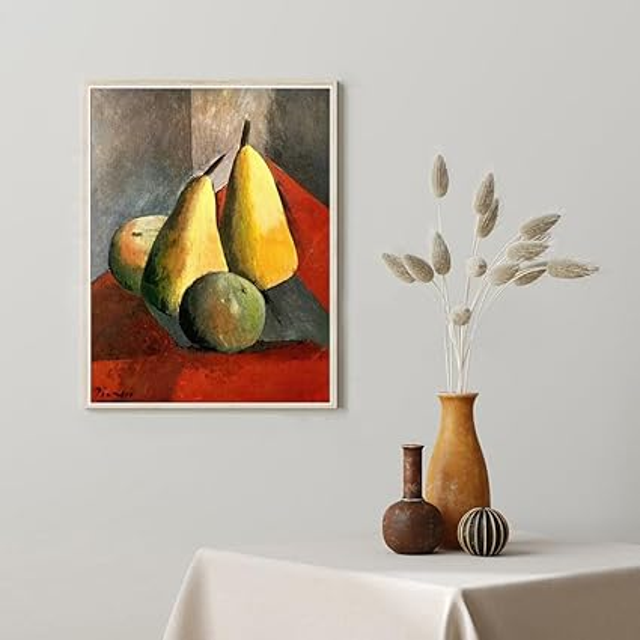

In [121]:
yolo = YOLO(path)
image_url = "guess.jpg"
run_yolo(yolo, image_url)  